# Pipelines de Machine Learning y GridSearchCV

Después de completar este laboratorio, serás capaz de:

Construir y evaluar un pipeline de Machine Learning.

Implementar GridSearchCV para ajuste de hiperparámetros con validación cruzada.

Implementar y optimizar un pipeline de clasificación complejo usando datos del mundo real.

Extraer las importancias de las características de un pipeline entrenado.

Introducción

En los flujos de trabajo de Machine Learning, la clase Pipeline de Scikit-Learn es invaluable para integrar el preprocesamiento de datos y el entrenamiento del modelo en una secuencia coherente. Un pipeline es esencialmente una secuencia de transformadores de datos que culmina con un predictor final opcional. Esta estructura permite que las mismas transformaciones aplicadas durante el entrenamiento se apliquen de manera consistente a nuevos datos durante la predicción.

Cada paso intermedio en un pipeline debe ser un transformador, es decir, debe implementar los métodos fit y transform. El paso final, que normalmente es un modelo predictivo o estimador, solo requiere el método fit. Todo el pipeline puede entrenarse simultáneamente usando, por ejemplo, GridSearchCV, resultando en un predictor autosuficiente que puede usarse para predecir datos no vistos.

Un aspecto importante es que el pipeline permite configurar los parámetros de cada paso usando los nombres de los pasos y los parámetros conectados por un doble guion bajo __. Por ejemplo, si un paso se llama imputer y quieres cambiar su estrategia, puedes pasar un parámetro como imputer__strategy='median'. Además, los pasos pueden ser reemplazados completamente asignando un estimador diferente o incluso omitidos configurándolos como 'passthrough' o None.

Una gran ventaja de usar un pipeline es que permite realizar validación cruzada y ajuste de hiperparámetros de manera integral para todos los pasos al mismo tiempo. Al integrar el pipeline dentro de GridSearchCV, puedes optimizar no solo el modelo, sino también los pasos de preprocesamiento, logrando un rendimiento global mejorado. Los pipelines son esenciales cuando el preprocesamiento incluye operaciones como escalado, codificación de variables categóricas, imputación de valores faltantes y reducción de dimensionalidad, asegurando que estos pasos se apliquen de manera reproducible tanto a los datos de entrenamiento como a los de prueba.

En este laboratorio aprenderás a:

Generar datos sintéticos para realizar experimentos específicos usando scikit-learn.

Entrenar y evaluar un modelo de clasificación KNN usando un pipeline.

Ajustar los hiperparámetros del modelo utilizando un pipeline dentro de una búsqueda en cuadrícula con validación cruzada.

Construir un pipeline de clasificación más complejo con Random Forest usando datos del mundo real.

Extraer las importancias de las características del pipeline entrenado.

El objetivo de este laboratorio es aprender a construir y optimizar un modelo de Machine Learning complejo utilizando un pipeline y validación cruzada para ajustar sus hiperparámetros.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix

Entrenar un modelo usando un pipeline

Comenzaremos con un ejemplo de cómo construir un pipeline, ajustarlo a los datos de Iris y evaluar su precisión (accuracy).

In [2]:
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

## Crear una instancia de un pipeline que consista en StandardScaler, PCA y KNeighborsClassifier

In [3]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Step 1: Standardize features
    ('pca', PCA(n_components=2),),       # Step 2: Reduce dimensions to 2 using PCA
    ('knn', KNeighborsClassifier(n_neighbors=5,))  # Step 3: K-Nearest Neighbors classifier
])

## Ejercicio 1. Divide los datos en conjuntos de entrenamiento y prueba

Asegúrate de estratificar la variable objetivo.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Ajustar el pipeline al conjunto de entrenamiento

El pipeline consiste en una secuencia de tres estimadores y debe considerarse como el modelo de Machine Learning que estamos entrenando y evaluando.

Procedamos a ajustar el modelo a los datos de entrenamiento y evaluemos su precisión (accuracy).

In [5]:
pipeline.fit(X_train, y_train)

# Measure the pipeline accuracy on the test data
test_score = pipeline.score(X_test, y_test)
print(f"{test_score:.3f}")

0.900


### Obtener las predicciones del modelo

In [6]:
y_pred = pipeline.predict(X_test)

### Ejercicio 2. Genera la matriz de confusión para el modelo KNN y represéntala gráficamente

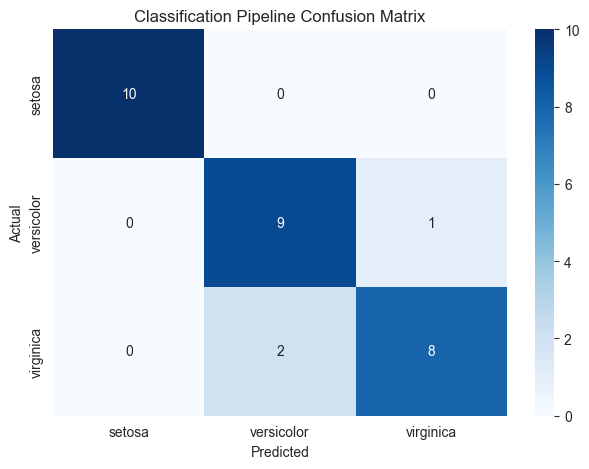

In [7]:
# generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a plot for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('Classification Pipeline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

Ejercicio 3. Describe los errores cometidos por el modelo.

El modelo clasificó incorrectamente dos iris virginica como versicolor y un versicolor como virginica. ¡Nada mal, solo tres errores de clasificación de 30 iris en nuestro primer intento!

## Ajuste de hiperparámetros usando un pipeline con búsqueda en cuadrícula y validación cruzada

Hemos creado un modelo, pero aún no hemos intentado optimizar su rendimiento. Veamos si podemos mejorarlo.

Recuerda que sería un error ejecutar el modelo repetidamente con diferentes hiperparámetros para encontrar el mejor, ya que esto llevaría a sobreajustar el modelo a tu conjunto de prueba.

La manera correcta de ajustar los hiperparámetros es usando validación cruzada (cross-validation).

Veamos cómo funciona, utilizando el mismo conjunto de datos.

## Crear una instancia del pipeline

Preprocesaremos los datos escalándolos y transformándolos a un número determinado de componentes principales (PCA), luego aplicaremos un clasificador KNN, y combinaremos estos estimadores en un pipeline.

Después, optimizaremos el pipeline usando validación cruzada sobre una búsqueda en cuadrícula de hiperparámetros, lo que nos permitirá encontrar el mejor modelo para el conjunto de hiperparámetros de prueba.


In [8]:
# make a pipeline without specifying any parameters yet
pipeline = Pipeline(
                    [('scaler', StandardScaler()),
                     ('pca', PCA()),
                     ('knn', KNeighborsClassifier())
                    ]
                   )

## Definir una rejilla de hiperparámetros para la búsqueda

In [9]:
# Hyperparameter search grid for numbers of PCA components and KNN neighbors
param_grid = {'pca__n_components': [2, 3],
              'knn__n_neighbors': [3, 5, 7]
             }

## Elegir un método de validación cruzada

Para asegurar que la variable objetivo esté estratificada, podemos usar la clase StratifiedKFold de scikit-learn para la validación cruzada.

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Ejercicio 4. Determina los mejores parámetros

Pasa tu **`pipeline`**, **`param_grid`** y el método de validación cruzada **`StratifiedKFold`** a **`GridSearchCV`**.


In [11]:
best_model = GridSearchCV(estimator=pipeline,
                          param_grid=param_grid,
                          cv=cv,
                          scoring='accuracy',
                          verbose=2
                         )

## Ajustar el mejor modelo de GridSearchCV a los datos de entrenamiento

In [13]:
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'pca__n_components': [2, 3]},
             scoring='accuracy', verbose=2)

Explora el gráfico de GridSearchCV que muestra la estructura de tu estimador, incluyendo los hiperparámetros encontrados para el mejor estimador.

Puedes obtener ayuda específica sobre cada componente haciendo clic en su signo de interrogación.

## Ejercicio 5. Evalúa la precisión (accuracy) del mejor modelo en el conjunto de prueba

In [14]:
test_score = best_model.score(X_test, y_test)
print(f"{test_score:.3f}")

0.933


Hemos logrado una mejora significativa en la precisión, pasando del 90% al 93%.

Mostramos los mejores parametros

In [15]:
best_model.best_params_

{'knn__n_neighbors': 3, 'pca__n_components': 3}

## Graficar la matriz de confusión para las predicciones en el conjunto de prueba

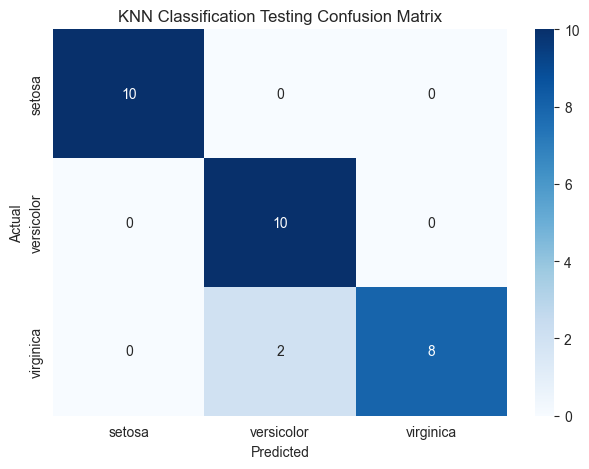

In [16]:
y_pred = best_model.predict(X_test)

# Generate the confusion matrix for KNN
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a single plot for the confusion matrix
plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=labels, yticklabels=labels)

# Set the title and labels
plt.title('KNN Classification Testing Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

¡Impresionante! Solo hubo dos errores, donde se predijo Versicolor pero el iris era en realidad Virginica.

Con esto concluye el laboratorio. Ahora cuentas con una metodología avanzada para construir modelos de Machine Learning sofisticados desde cero. Aun así, hay mucho más por aprender. Explorar el conjunto de ejemplos de scikit-learn y consultar su documentación de ayuda es fundamental; siempre aprenderás algo nuevo. Por supuesto, no hay sustituto para adquirir experiencia mediante la práctica.

Ahora es momento de arremangarse y sumergirse en el Proyecto Práctico.